### Wstęp

Niniejszy notatnik przedstawia implementację algorytmu genetycznego, który został zastosowany do rozwiązania dwóch złożonych problemów optymalizacyjnych: problemu plecakowego (Knapsack Problem) oraz problemu trasowania pojazdów (Vehicle Routing Problem, VRP). Proces implementacji obejmuje generowanie danych wejściowych, definiowanie funkcji oceny, optymalizację tras dla pojazdów oraz wizualizację wyników w formie interaktywnych map. 

Wszystkie eksperymenty zostały przeprowadzone przy użyciu kernela w wersji **Python 3.12.8**, co zapewniło pełną kompatybilność z wykorzystywanymi bibliotekami, takimi jak **DEAP**, **OSMnx** i **OR-Tools**. Podczas projektowania kodu szczególny nacisk położono na modularność, co umożliwia łatwe dostosowanie parametrów, takich jak liczba klientów, pojemność pojazdów czy wybrana heurystyka. Dzięki temu rozwiązanie może być łatwo adaptowane do różnych wariantów problemów optymalizacyjnych. 

W notatniku zaprezentowano dwie różne heurystyki dla generowania danych wejściowych. W pewnym momencie użytkownik ma możliwość wyboru jednej z nich, co zostało wprowadzone w celu zachowania integralności notatnika. Aby jednak testy były w pełni powtarzalne i niezależne od poprzednich wykonanych komórek, przed zmianą heurystyki należy zresetować cały notatnik. Taki zabieg umożliwia przeprowadzenie eksperymentów z użyciem jednej heurystyki, a następnie przejście na drugą bez ryzyka wprowadzenia niezamierzonych błędów wynikających z zależności pomiędzy komórkami.

Dodatkowo wprowadzono rozwiązanie problemu CVRP (Capacitated Vehicle Routing Problem) z wykorzystaniem biblioteki OR-Tools, które pełni rolę punktu odniesienia dla implementacji algorytmu genetycznego. OR-Tools, jako narzędzie opracowane przez Google, dostarcza sprawdzonego podejścia do rozwiązywania problemów optymalizacyjnych, co czyni je użytecznym benchmarkiem do porównań. Choć problem CVRP rozwiązywany przy pomocy OR-Tools nie jest identyczny z modelem zaimplementowanym w algorytmie genetycznym (m.in. z powodu z góry ustalonej liczby pojazdów), jest on wystarczająco zbliżony, aby umożliwić porównanie wyników i ocenić efektywność oraz jakość rozwiązań generowanych przez oba podejścia. CVRP z OR-Tools pozwala na precyzyjne modelowanie ograniczeń pojemności oraz minimalizację kosztów tras, co czyni je wartościowym narzędziem analitycznym i odniesieniem dla wyników uzyskanych za pomocą algorytmów genetycznych.

### Importowanie bibliotek i konfiguracja środowiska

Na początku przygotowujemy środowisko i dane wejściowe dla algorytmów genetycznych. Funkcja **`set_seed()`** będzie służyć ustawieniu ziarna, co zapewni stabilność wyników testów i eksperymentów.

#### Importowanie bibliotek:

- **`osmnx`**: Umożliwia pobieranie i przetwarzanie danych sieci drogowych z OpenStreetMap.
- **`networkx`**: Biblioteka do manipulacji i analizy grafów, używana tutaj w połączeniu z osmnx do obliczeń w sieci drogowej.
- **`deap`**: Biblioteka do implementacji algorytmów genetycznych.
- **`base`**: Podstawowe klasy i metody dla algorytmów ewolucyjnych.
- **`creator`**: Służy do tworzenia niestandardowych typów obiektów, takich jak funkcje dopasowania.
- **`tools`**: Zbiór narzędzi pomocniczych, np. selekcja, mutacja, krzyżowanie.
- **`random`**: Biblioteka standardowa do generowania liczb losowych.
- **`numpy`**: Używana do obliczeń numerycznych i pracy z tablicami.
- **`folium`**: Biblioteka do wizualizacji danych na mapach (np. tras pojazdów na mapie miasta).

#### Ustawienie ziarna

Ziarno **`SEED`** to początkowa wartość używana przez generator liczb pseudolosowych, która pozwala na odtworzenie tych samych "losowych" wyników przy każdorazowym uruchomieniu programu. Ustawiamy jego wartość na 2025 – jest to liczba wybrana losowo, lecz nie przypadkowo, co ma podkreślić obiektywność  przebiegu eksperymentów, pokazując, że ziarno nie zostało dobrane celowo w celu uzyskania lepszych wyników.

In [1]:
# Importowanie bibliotek
import osmnx as ox
import networkx as nx
from deap import base, creator, tools
import random
import numpy as np
import folium
import matplotlib.pyplot as plt

# Konfiguracja powtarzalności wyników
def set_seed(SEED=2025):
    import random
    import numpy as np
    random.seed(SEED)
    np.random.seed(SEED)
    print(f"Ziarno ustawione na: {SEED}")

# Wywołanie funkcji
set_seed()

Ziarno ustawione na: 2025


### Parametry globalne i generowanie danych

Następnie definiujemy parametry dla problemu logistycznego, definiujemy przestrzeń oraz lokalizacje magazynu i klientów, na których operują dalsze algorytmy.

Parametry problemu:
 - **`NUM_CUSTOMERS`**: Liczba klientów, dla których muszą być zaplanowane trasy. Odpowiednia liczba dla naszego problemu może wynosić 50, wtedy zagęszczenie klientów nie jest za duże ani za małe.

- **`VEHICLE_CAPACITY`**: Pojemność jednego pojazdu (np. maksymalna waga lub liczba paczek, które pojazd może przewieźć). Ustawiono na 100, co jest prostym punktem odniesienia dla późniejszego generowania rozmiarów paczek.

- **`POP_SIZE`**: Rozmiar populacji w algorytmie genetycznym. Wynosi 100, ponieważ jest to dobry kompromis dla problemu o średniej skali (tj. 50 klientów).

- **`CXPB`**: Prawdopodobieństwo krzyżowania (crossover probability). Wartość 0.8 oznacza, że 80% par osobników w populacji zostanie skrzyżowanych. Ta wartość jest rozsądnym punktem wyjścia, ponieważ zapewnia balans między eksploracją (odkrywaniem nowych rozwiązań) a eksploatacją (wykorzystywaniem już znalezionych dobrych rozwiązań). Jej optymalność dla konkretnego problemu została zweryfikowana przez testy różnych wartości dla algorytmów.

- **`MUTPB`**: Prawdopodobieństwo mutacji (mutation probability). Wynosi 0.2, co oznacza, że 20% osobników w populacji może podlegać mutacji. Podobnie jak w przypadku krzyżowania, ta wartość mutacji jest dobrym kompromisem dla naszego przykładu, pozwala na eksplorację przestrzeni rozwiązań bez zakłócania procesu eksploatacji, tym samym zapobiegając stagnacji. Optymalność tej wartości również została poparta testami.

- **`MAX_GENERATIONS`**S: Maksymalna liczba generacji w algorytmie genetycznym. Ustawiono na 500. Wartość ta została dobrana eksperymentalnie, przy różnych parametrach wejściowych wykazywała ona się ona odpowiedni poziom eksploracji oraz ulepszania. Po określonej liczbie generacji populacja zwykle stabilizuje się, bez potrzeby większej liczby iteracji.

- **`CENTER_LOCATION`**: Współrzędne geograficzne centrum Krakowa (50.0619474, 19.9368564).

- **`RADIUS`**: Promień w metrach wokół centrum Krakowa, w którym zostaną wygenerowani klienci. Ustawiono na 5000 metrów.

#### Generowanie grafu:

Funkcja **'generate_locations'** tworzy graf drogowy i losowo wybiera lokalizacje magazynu i klientów, używając jako danych wejściowych num_customers, center_location, radius.

#### Działanie funkcji:
- ox.graph_from_point: Tworzy graf drogowy dla wyznaczonego promienia wokół podanego punktu (używając biblioteki OSMnx).
- ox.utils_graph.get_largest_component: Filtruje największą spójną składową grafu, aby uniknąć problemów z rozłącznymi częściami grafu.
- random.choice: Wybiera losowy węzeł jako lokalizację magazynu (depot_node).
- random.sample: Losowo wybiera num_customers węzłów jako lokalizacje klientów (customer_nodes).

#### Wynik działania funkcji:
- graph: Graf drogowy obejmujący drogi w promieniu 5000 metrów od centrum Krakowa.
- depot_node: Lokalizacja magazynu (węzeł grafu).
- customer_nodes: Lista węzłów grafu reprezentujących lokalizacje klientów.

In [2]:
# Parametry problemu
NUM_CUSTOMERS = 50
VEHICLE_CAPACITY = 100
POP_SIZE = 100
CXPB = 0.8  
MUTPB = 0.2  
MAX_GENERATIONS = 500
CENTER_LOCATION = (50.0619474, 19.9368564)  
RADIUS = 5000 

def generate_locations(num_customers, center_location, radius, max_attempts=5):
    attempt = 0
    while attempt < max_attempts:
        try:
            # Generowanie grafu drogowego
            graph = ox.graph_from_point(center_location, dist=radius, network_type="drive")
            undirected_graph = graph.to_undirected()

            # Sprawdzenie, czy graf jest spójny
            if not nx.is_connected(undirected_graph):
                print(f"Graf nie jest spójny. Próba {attempt + 1}/{max_attempts}. Wybieramy największy komponent.")
                largest_component_nodes = max(nx.connected_components(undirected_graph), key=len)
                graph = graph.subgraph(largest_component_nodes).copy()

            # Lista węzłów w największym komponencie
            nodes = list(graph.nodes)

            # Walidacja liczby klientów względem dostępnych węzłów
            if num_customers > len(nodes) - 1:
                raise ValueError(
                    f"Nie można przypisać {num_customers} klientów. "
                    f"Graf ma tylko {len(nodes)} dostępnych węzłów."
                )

            # Losowy wybór magazynu
            depot_node = random.choice(nodes)

            # Losowy wybór klientów, upewniając się, że magazyn nie jest klientem
            customer_nodes = random.sample([node for node in nodes if node != depot_node], num_customers)

            # Sprawdzenie, czy wszyscy klienci są osiągalni z magazynu
            for node in customer_nodes:
                if not nx.has_path(graph, depot_node, node):
                    raise ValueError(f"Klient {node} nie jest osiągalny z magazynu {depot_node}.")

            print("Graf wygenerowany pomyślnie.")
            print(f"Liczba węzłów: {len(nodes)}, Magazyn: {depot_node}, Klienci: {customer_nodes}")

            return graph, depot_node, customer_nodes

        except ValueError as e:
            print(f"Próba {attempt + 1}/{max_attempts} nie powiodła się: {e}")
            attempt += 1

    # Jeśli po określonej liczbie prób graf nadal jest niepoprawny, zgłaszamy wyjątek
    raise ValueError(f"Nie udało się wygenerować poprawnego grafu po {max_attempts} próbach.")

# Generowanie grafu i lokalizacji
graph, depot_node, customer_nodes = generate_locations(NUM_CUSTOMERS, CENTER_LOCATION, RADIUS)
print("Graf drogowy i węzły wygenerowane.")


Graf wygenerowany pomyślnie.
Liczba węzłów: 5156, Magazyn: 7098641741, Klienci: [257659369, 2696918412, 283705702, 4716344526, 30372002, 1405864429, 1417650573, 9038429924, 321373867, 245421632, 1504913954, 1728822219, 262199980, 227455499, 269656158, 290286034, 1417650570, 262210524, 1803095902, 236101995, 11113252685, 207476206, 6718657325, 3774612217, 245423859, 288496778, 288145415, 207457002, 316800912, 1710281170, 2419720318, 1222395388, 4176587782, 207516230, 10226388234, 266684914, 5906305395, 288929703, 290273249, 272303105, 322678855, 10966186567, 207522798, 269330748, 275424728, 6643622531, 1366387731, 261673883, 9981773233, 2419732962]
Graf drogowy i węzły wygenerowane.


### Funkcje Pomocnicze

Ta komórka zawiera kluczowe funkcje pomocnicze, które wspierają działanie algorytmu genetycznego w problemie optymalizacji tras pojazdów:

#### Heurystyki generowania danych

1. **`generate_random_package_sizes_and_distance_weights`**  
   Tworzy rozmiary paczek (`package_sizes`) oraz wagi (`weights`), bazując na odległościach klientów od magazynu i lokalnym zagęszczeniu klientów.  
**Cechy:**
- Paczki są losowe w zakresie 5–20.
- Wagi uwzględniają:
  - Odległość klienta od magazynu.
  - Zagęszczenie klientów w okolicy.
- Preferuje większe paczki, zmniejszając ich względne "koszty" wagowe.


2. **`generate_random_package_sizes_and_scaled_weights`**  
   Tworzy rozmiary paczek (`package_sizes`) i wagi (`weights`), skalując je w oparciu o odległość od najdalszego klienta.  
**Cechy:**
- Paczki są losowe w zakresie 5–20.
- Wagi są odwrotnie proporcjonalne do odległości od najdalszego klienta.

3. **`generate_heuristic_data`**  
   - Umożliwia dynamiczny wybór jednej z dwóch heurystyk (`distance_weights` lub `scaled_weights`) w zależności od wybranego typu.

#### Funkcja naprawcza

- **`repair_individual_max_capacity`**  
  Naprawia rozwiązania, które przekraczają pojemność pojazdów.  
**Zasady działania:**
- Dla każdego klienta, jeśli dany pojazd przekracza pojemność:
  1. Szuka innego pojazdu z wystarczającym wolnym miejscem.
  2. Przenosi paczkę do najlepiej dopasowanego pojazdu, minimalizując niewykorzystaną pojemność.
- Jeśli nie ma dostępnych pojazdów z wystarczającą pojemnością, paczka pozostaje w dotychczasowym pojeździe.

#### Obliczanie macierzy odległości

- **`calculate_distance_matrix`**  
  - Tworzy macierz odległości między wszystkimi węzłami (magazynem i klientami) w grafie.
  - Używa najkrótszych ścieżek z wagą odległości (`length`) w grafie drogowym.

Funkcje te stanowią fundament algorytmu genetycznego, pozwalając na generowanie danych wejściowych, naprawę rozwiązań i ocenę ich jakości.


In [3]:
# pierwsza haurystyka

def generate_random_package_sizes_and_distance_weights(graph, depot_node, customer_nodes):
    """
    Generuje losowe wartości paczek oraz wagi, z priorytetem maksymalnego wykorzystania pojemności pojazdów
    oraz uwzględnieniem lokalnego zagęszczenia klientów.
    """
    distances_from_depot = {
        node: nx.shortest_path_length(graph, depot_node, node, weight="length")
        for node in customer_nodes
    }
    max_distance = max(distances_from_depot.values())

    package_sizes = []
    weights = []
    nearby_customers_list = []
    max_nearby_customers = 0

    # Oblicz liczbę pobliskich klientów dla każdego klienta
    for node in customer_nodes:
        nearby_customers = sum(
            1 for neighbor in customer_nodes
            if nx.shortest_path_length(graph, node, neighbor, weight="length") < 500
        )
        nearby_customers_list.append(nearby_customers)
        if nearby_customers > max_nearby_customers:
            max_nearby_customers = nearby_customers

    for i, node in enumerate(customer_nodes):
        distance_to_depot = distances_from_depot[node]
        nearby_customers = nearby_customers_list[i]
        
        # Losowa wartość paczki
        value = random.randint(5, 20)
        package_sizes.append(value)

        # Nowa heurystyka: mniej znaczenia odległości, większy wpływ zagęszczenia
        normalized_nearby = nearby_customers / (max_nearby_customers + 1)
        #weight = (value / 20) * (1 + 0.3 * distance_to_depot / max_distance) / (1 + 3 * normalized_nearby)
        weight = (value / 20) * (1 + 0.2 * distance_to_depot / max_distance) / (1 + 5 * normalized_nearby)
        # Kara za "mniejsze paczki" - premiowanie większych ładunków
        weight *= 1 + (1 - value / 20)

        weights.append(weight)

    return package_sizes, weights

# heurystyka najdalszego klienta

def generate_random_package_sizes_and_scaled_weights(graph, depot_node, customer_nodes):
    distances_from_depot = {
        node: nx.shortest_path_length(graph, depot_node, node, weight="length")
        for node in customer_nodes
    }
    farthest_client_distance = max(distances_from_depot.values())
    package_sizes = []
    weights = []
    epsilon = 1e-6

    for node in customer_nodes:
        value = random.randint(5, 20)
        package_sizes.append(value)

        # Skalowanie wagi
        weight = (value / 20) * (1 / (distances_from_depot[node] + epsilon))
        weight = max(weight, 0.1)  # Minimalna waga dla stabilności
        weights.append(weight)

    return package_sizes, weights




def repair_individual_max_capacity(individual, package_sizes, vehicle_capacity):
    vehicle_values = {}
    for i, vehicle in enumerate(individual):
        if vehicle not in vehicle_values:
            vehicle_values[vehicle] = 0
        vehicle_values[vehicle] += package_sizes[i]
    
    # Przepakowanie klientów do innych pojazdów
    for i, vehicle in enumerate(individual):
        if vehicle_values[vehicle] > vehicle_capacity:
            # Znajdź pojazd, który najlepiej dopasuje paczkę, nie przekraczając limitu
            best_fit_vehicle = None
            min_remaining_capacity = float("inf")
            
            for v in range(len(vehicle_values)):
                remaining_capacity = vehicle_capacity - vehicle_values.get(v, 0)
                if remaining_capacity >= package_sizes[i] and remaining_capacity < min_remaining_capacity:
                    best_fit_vehicle = v
                    min_remaining_capacity = remaining_capacity
            
            if best_fit_vehicle is not None:
                # Przenieś paczkę do najlepiej dopasowanego pojazdu
                vehicle_values[vehicle] -= package_sizes[i]
                vehicle_values[best_fit_vehicle] = vehicle_values.get(best_fit_vehicle, 0) + package_sizes[i]
                individual[i] = best_fit_vehicle
            else:
                # Jeśli nie można dopasować, pozostaw paczkę (można dodać dodatkową karę, jeśli to konieczne)
                continue

    return individual

def generate_heuristic_data(heuristic_type, graph, depot_node, customer_nodes):
    if heuristic_type == "distance_weights":
        return generate_random_package_sizes_and_distance_weights(graph, depot_node, customer_nodes)
    elif heuristic_type == "scaled_weights":
        return generate_random_package_sizes_and_scaled_weights(graph, depot_node, customer_nodes)
    else:
        raise ValueError("Unsupported heuristic type!")



# Obliczanie macierzy odległości
def calculate_distance_matrix(nodes, graph):
    matrix = np.zeros((len(nodes), len(nodes)))
    for i, from_node in enumerate(nodes):
        for j, to_node in enumerate(nodes):
            if i != j:
                try:
                    matrix[i, j] = nx.shortest_path_length(graph, from_node, to_node, weight="length")
                except nx.NetworkXNoPath:
                    matrix[i, j] = float("inf")
    return matrix

nodes = [depot_node] + customer_nodes
distance_matrix = calculate_distance_matrix(nodes, graph)

### Konfiguracja DEAP i funkcje oceny

Poniżej definiujemy podstawowe mechanizmy genetyczne i funkcje oceny w algorytmie genetycznym dla problemu. Dynamiczny wybór heurystyki pozwala na łatwe przełączanie się między różnymi metodami generowania danych.

#### Konfiguracja DEAP
Za pomocą biblioteki DEAP definiujemy podstawowe elementy algorytmu genetycznego:

1. **Fitness i Osobniki:**
   - `FitnessMin`: Definicja minimalizującej funkcji fitness z dwoma celami o przypisanych wartościach **weights=(-1.0, -1.0)**, ponieważ chcemy minimalizować liczbę pojazdów i całkowity koszt transportu.
   - `Individual`: Definicja osobnika jako listy z powiązanym obiektem fitness **(`FitnessMin`)**.

2. **Toolbox:**
   - Narzędzie DEAP do definiowania operacji genetycznych, takich jak selekcja, krzyżowanie i mutacja.

#### Parametry:
- `LARGE_PENALTY`: Wysoka kara (10⁶) za przekroczenie pojemności pojazdów.

#### Funkcje:

1. **`evaluate_with_weights_and_capacity(individual)`**:
   - Oblicza obciążenie pojazdów oraz koszt tras według kroków:
     1. Oblicz obciążenie pojazdów na podstawie `package_sizes`.
     2. Nałóż karę za przekroczenie pojemności pojazdów.
     3. Oblicz koszt transportu uwzględniając wagi (`weights`) i odległości pomiędzy węzłami.
   - Zwraca liczbę użytych pojazdów oraz sumaryczny koszt (z karą za przeciążenie).

2. **`repair_individual(individual)`**:
   - Naprawia osobniki, które przekraczają pojemność pojazdów.
   - Dla klientów w przeciążonym pojeździe losowo przypisuje nowy pojazd.

#### Heurystyka:
- Mechanizm wyboru heurystyki (`scaled_weights` lub `distance_weights`) wpływa na sposób generowania `package_sizes` i `weights`.



#### Rejestracja funkcji w DEAP:

- **`evaluate`**: Funkcja oceny (`evaluate_with_weights_and_capacity`) oblicza liczbę pojazdów oraz całkowity koszt, uwzględniając wagę tras i ograniczenia pojemności.
- **`attr_vehicle`**: Generator losowo przypisuje klienta do pojazdu, co wprowadza zróżnicowanie w populacji początkowej.
- **`individual`**: Reprezentuje jednego osobnika jako listę przypisań klientów do pojazdów – prosty i efektywny sposób modelowania problemu.
- **`population`**: Tworzy populację składającą się z wielu osobników, co umożliwia eksplorację większej przestrzeni rozwiązań.
- **`mate` (`cxUniform`)**: Krzyżowanie równomierne wymienia losowe elementy między dwoma rodzicami, co zapewnia różnorodność i możliwość wymiany dobrych cech.
- **`mutate` (`mutShuffleIndexes`)**: Mutacja polegająca na przetasowaniu klientów w osobniku – pomaga uniknąć lokalnych minimów poprzez wprowadzanie drobnych zmian.
- **`select` (`selTournament`)**: Selekcja turniejowa (rozmiar turnieju 3) wybiera najlepszych osobników z małych grup – równoważy eksplorację (badanie przestrzeni rozwiązań) i eksploatację (wybieranie dobrych rozwiązań).





In [4]:
# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Funkcja oceny
LARGE_PENALTY = 10**6  # Kara za przekroczenie pojemności


def evaluate_with_weights_and_capacity(individual):
    vehicle_loads = [0] * NUM_CUSTOMERS  # Obciążenie na podstawie package_sizes
    total_cost = 0
    used_vehicles = set()

    # Oblicz obciążenie pojazdów i koszt
    for client, vehicle in enumerate(individual):
        vehicle_loads[vehicle] += package_sizes[client]  # Package_sizes ograniczają przestrzeń pakowną
        used_vehicles.add(vehicle)

    # Kara za przekroczenie pojemności na podstawie package_sizes
    overload_penalty = sum(
        max(0, load - VEHICLE_CAPACITY) * LARGE_PENALTY for load in vehicle_loads
    )

    # Obliczenie kosztu transportu z uwzględnieniem weights
    for vehicle in used_vehicles:
        vehicle_clients = [i for i, v in enumerate(individual) if v == vehicle]
        vehicle_nodes = [customer_nodes[c] for c in vehicle_clients]
        vehicle_nodes = [depot_node] + vehicle_nodes + [depot_node]
        for i in range(len(vehicle_nodes) - 1):
            client_index = nodes.index(vehicle_nodes[i + 1]) - 1
            weight_factor = weights[client_index] if client_index >= 0 else 1
            total_cost += distance_matrix[nodes.index(vehicle_nodes[i]), nodes.index(vehicle_nodes[i + 1])] * weight_factor

    return len(used_vehicles), total_cost + overload_penalty



# Naprawa osobników
def repair_individual(individual):
    vehicle_values = [0] * NUM_CUSTOMERS
    for client, vehicle in enumerate(individual):
        vehicle_values[vehicle] += package_sizes[client]

    for vehicle, value in enumerate(vehicle_values):
        if value > VEHICLE_CAPACITY:
            overloaded_clients = [
                i for i, v in enumerate(individual) if v == vehicle and vehicle_values[v] > VEHICLE_CAPACITY
            ]
            for client in overloaded_clients:
                individual[client] = random.randint(0, NUM_CUSTOMERS - 1)
    return individual


# Wybór heurystyki
heuristic_type = "distance_weights"  # "scaled_weights" lub "distance_weights"
package_sizes, weights = generate_heuristic_data(heuristic_type, graph, depot_node, customer_nodes)



# Rejestracja funkcji w DEAP
toolbox.register("evaluate", evaluate_with_weights_and_capacity)
toolbox.register("attr_vehicle", lambda: random.randint(0, NUM_CUSTOMERS - 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_vehicle, n=NUM_CUSTOMERS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


### Algorytm genetyczny problemu plecakowego

#### Opis komórki:

Ta komórka implementuje algorytm genetyczny w celu rozwiązania problemu plecakowego, uwzględniającego ograniczenia pojemności pojazdów i optymalizację tras. 

#### Kroki algorytmu:
1. **Inicjalizacja populacji**:
   - Populacja (`pop`) jest generowana z losowo przypisanych klientów do pojazdów przy użyciu funkcji `toolbox.population`.

2. **Naprawa populacji**:
   - Każdy osobnik jest naprawiany przy użyciu funkcji `repair_individual`, aby wstępnie dostosować przypisania klientów do pojazdów do ograniczeń pojemności.

3. **Ewaluacja populacji**:
   - Funkcja `toolbox.evaluate` ocenia każdego osobnika na podstawie liczby użytych pojazdów i całkowitego kosztu transportu.

4. **Ewolucja**:
   - Dla każdej generacji:
     - **Selekcja**: Najlepsi osobnicy są wybierani do nowego pokolenia przy użyciu selekcji turniejowej.
     - **Krzyżowanie**: Z wybranych osobników 80% par jest krzyżowanych (`CXPB = 0.8`), aby wymieniać ich cechy.
     - **Mutacja**: 20% osobników jest mutowanych (`MUTPB = 0.2`), aby wprowadzić losowe zmiany.
     - **Naprawa**: Naprawiane są osobniki przekraczające pojemność pojazdów.
     - **Ewaluacja**: Niepoprawni osobnicy są ponownie oceniani.

5. **Wyniki**:
   - Najlepszy osobnik w populacji jest wybierany przy użyciu funkcji `tools.selBest`.
   - Wyświetlane są szczegóły rozwiązania, takie jak liczba pojazdów, przypisanie klientów do pojazdów i całkowity koszt transportu.

#### Parametry:
- **`CXPB = 0.8`**: Wysokie prawdopodobieństwo krzyżowania sprzyja wymianie dobrych cech między osobnikami.
- **`MUTPB = 0.2`**: Umiarkowane prawdopodobieństwo mutacji zapewnia eksplorację przestrzeni rozwiązań.
- **`MAX_GENERATIONS = 500`**: Duża liczba generacji pozwala na dokładne zbliżenie do rozwiązania optymalnego.

#### Wyniki:
Na końcu komórki wyświetlane są uporządkowane przypisania klientów do pojazdów oraz informacje o spełnieniu ograniczeń pojemności pojazdów.


Ziarno ustawione na: 2025
Generacja 1: Pojazdy = 27.0, Koszt = 282405.2577392105
Generacja 2: Pojazdy = 25.0, Koszt = 289673.7560906483
Generacja 3: Pojazdy = 25.0, Koszt = 270365.9203294517
Generacja 4: Pojazdy = 22.0, Koszt = 236758.20303541186
Generacja 5: Pojazdy = 25.0, Koszt = 267104.88381212484
Generacja 6: Pojazdy = 25.0, Koszt = 266578.39154566225
Generacja 7: Pojazdy = 23.0, Koszt = 251680.60088061623
Generacja 8: Pojazdy = 23.0, Koszt = 286440.2462911337
Generacja 9: Pojazdy = 20.0, Koszt = 256723.529950384
Generacja 10: Pojazdy = 20.0, Koszt = 256723.529950384
Generacja 11: Pojazdy = 22.0, Koszt = 259378.71929628984
Generacja 12: Pojazdy = 20.0, Koszt = 247501.7407211116
Generacja 13: Pojazdy = 19.0, Koszt = 235618.46172821408
Generacja 14: Pojazdy = 19.0, Koszt = 240209.9448505207
Generacja 15: Pojazdy = 17.0, Koszt = 212908.31834121328
Generacja 16: Pojazdy = 18.0, Koszt = 217726.7331961583
Generacja 17: Pojazdy = 17.0, Koszt = 199597.23195694428
Generacja 18: Pojazdy = 1

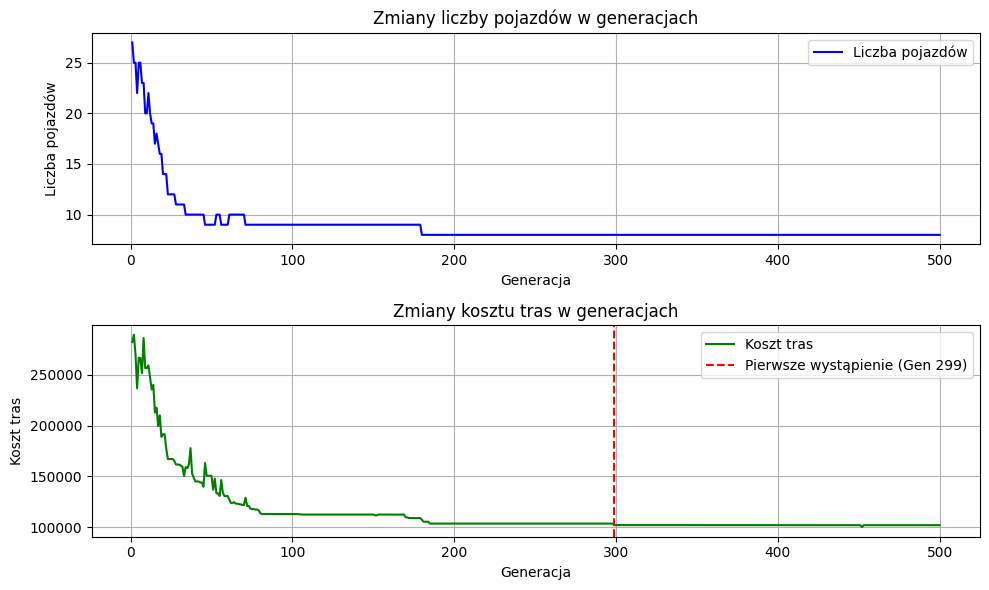

In [5]:

# Listy do gromadzenia danych
vehicles_per_gen = []
costs_per_gen = []

set_seed()

# Inicjalizacja populacji
pop = toolbox.population(n=POP_SIZE)

# Naprawa początkowej populacji
pop = [repair_individual(ind) for ind in pop]

# Ewaluacja początkowej populacji
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

# Algorytm genetyczny
for gen in range(MAX_GENERATIONS):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            mutant = repair_individual_max_capacity(mutant, package_sizes, VEHICLE_CAPACITY)

    offspring = [repair_individual(ind) for ind in offspring]

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox.evaluate(ind)

    pop[:] = offspring
    best_ind = tools.selBest(pop, 1)[0]

    # Zbieranie danych do analizy
    vehicles_per_gen.append(best_ind.fitness.values[0])
    costs_per_gen.append(best_ind.fitness.values[1])

    print(f"Generacja {gen + 1}: Pojazdy = {best_ind.fitness.values[0]}, Koszt = {best_ind.fitness.values[1]}")

# Wyświetlenie wyników
best_ind = tools.selBest(pop, 1)[0]
vehicle_assignments = {}
for client, vehicle in enumerate(best_ind):
    if vehicle not in vehicle_assignments:
        vehicle_assignments[vehicle] = []
    vehicle_assignments[vehicle].append(client + 1)

sorted_assignments = {i + 1: clients for i, (vehicle, clients) in enumerate(vehicle_assignments.items())}
print("\nNajlepsze rozwiązanie (po uporządkowaniu):")
for vehicle, clients in sorted_assignments.items():
    total_value = sum(package_sizes[client - 1] for client in clients)
    print(f"Pojazd {vehicle}: Klienci {clients}, Suma wartości = {total_value:.2f}, Ograniczenie = {VEHICLE_CAPACITY} {'(OK)' if total_value <= VEHICLE_CAPACITY else '(PRZEKROCZENIE)'}")


# Znajdź końcowy koszt
final_cost = costs_per_gen[-1]

# Znajdź pierwszą generację, w której pojawił się końcowy koszt
first_occurrence_gen = next(i + 1 for i, cost in enumerate(costs_per_gen) if cost == final_cost)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))

# Liczba pojazdów
plt.subplot(2, 1, 1)
plt.plot(range(1, len(vehicles_per_gen) + 1), vehicles_per_gen, label="Liczba pojazdów", color="blue")
plt.xlabel("Generacja")
plt.ylabel("Liczba pojazdów")
plt.title("Zmiany liczby pojazdów w generacjach")
plt.grid()
plt.legend()

# Koszt tras z oznaczeniem pierwszego wystąpienia końcowego kosztu
plt.subplot(2, 1, 2)
plt.plot(range(1, len(costs_per_gen) + 1), costs_per_gen, label="Koszt tras", color="green")
plt.axvline(x=first_occurrence_gen, color='red', linestyle='--', label=f"Pierwsze wystąpienie (Gen {first_occurrence_gen})")
plt.xlabel("Generacja")
plt.ylabel("Koszt tras")
plt.title("Zmiany kosztu tras w generacjach")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### Generowanie grafu

Kiedy mamy już gotowe możliwie zoptymalizowane zapakowane pojady, przechodzimy do optymalizacji tras dla poszczególnych pojazdów tak aby kolejność odwiedzania klientów, generowała jak najmniejszy koszt przejazdu. Do tego posłuży nam ponownie algorytm genetyczny, tylko przygotowany pod problem VRP.

Komórka odpowiada za wygenerowanie grafu drogowego, przypisanie klientów do pojazdów oraz weryfikację poprawności węzłów na potrzeby wizualizacji i dalszej analizy. Wynikowe dane służą do mapowania tras pojazdów i klientów w oparciu o rzeczywiste położenie węzłów grafu.


#### Szczegółowe kroki:

1. **Generowanie grafu drogowego:**
   - **`CENTER_LOCATION`:**
     - Punkt centralny grafu został ustawiony na współrzędne centrum Krakowa.
   - **`RADIUS`:**
     - Określa zasięg grafu jako okrąg o promieniu 5000 metrów od punktu centralnego.
   - **`ox.graph_from_point`:**
     - Tworzy graf drogowy typu "drive" (drogi przejezdne dla pojazdów).
   - **`ox.utils_graph.get_largest_component`:**
     - Wybiera największą spójną składową grafu, eliminując niepołączone fragmenty, aby zagwarantować spójność obliczeń.

2. **Wybór węzłów:**
   - **`nodes`:**
     - Lista węzłów grafu reprezentujących pozycje w sieci drogowej.

3. **Przypisanie klientów do pojazdów:**
   - **`vehicle_assignments`:**
     - Zmienna zawiera wynik przypisania klientów do pojazdów na podstawie rozwiązania problemu plecakowego (`sorted_assignments`).

4. **Walidacja węzłów:**
   - **Cel:**
     - Sprawdza, czy węzły przypisane klientom istnieją w grafie i są zgodne z listą `customer_nodes`.
   - **Funkcja `validate_nodes_in_graph`:**
     - Iteruje po węzłach przypisanych do każdego pojazdu.
     - Dla każdego klienta w węzłach sprawdza:
       - Czy indeks klienta nie wykracza poza zakres listy `customer_nodes`.
       - Czy odpowiadający węzeł grafu istnieje w `graph.nodes`.
     - W przypadku błędów generuje ostrzeżenia lub podnosi wyjątek.
   - **Efekt walidacji:**
     - Zapewnia, że dane wejściowe i wyjściowe algorytmu genetycznego są zgodne z grafem drogowym.

5. **Mapowanie klientów na węzły grafu:**
   - **`vehicle_to_nodes`:**
     - Tworzy mapowanie pojazdów na trasy z węzłami w grafie:
       - Trasa każdego pojazdu zaczyna się i kończy w magazynie (`depot_node`).
       - Węzły klientów (`customer_nodes`) są dodawane między początkiem i końcem trasy.
     - Używane do optymalizacji i wizualizacji tras.


#### Użyteczność:
- Graf drogowy, lista węzłów i mapowanie klientów na węzły stanowią podstawę:
  - Wizualizacji tras pojazdów w rzeczywistej topologii miasta.
  - Optymalizacji tras pojazdów w kolejnych etapach, takich jak algorytmy VRP.
  - Weryfikacji poprawności danych na podstawie zgodności z grafem.



In [6]:

# Generowanie grafu
CENTER_LOCATION = (50.0619474, 19.9368564)  # Centrum Krakowa
RADIUS = 5000  # Promień obszaru w metrach
graph = ox.graph_from_point(CENTER_LOCATION, dist=RADIUS, network_type="drive")
undirected_graph = graph.to_undirected()
largest_component_nodes = max(nx.connected_components(undirected_graph), key=len)


# Wybór węzłów
nodes = list(graph.nodes)

# Przypisanie klientów do pojazdów (wynik problemu plecakowego)
vehicle_assignments = sorted_assignments

# Walidacja węzłów
def validate_nodes_in_graph(graph, customer_nodes, vehicle_assignments):
    for vehicle, clients in vehicle_assignments.items():
        for client in clients:
            if client - 1 >= len(customer_nodes) or customer_nodes[client - 1] not in graph.nodes:
                print(f"Uwaga: Węzeł {client} nie istnieje w grafie lub jest poza zakresem.")
                return False
    return True

if not validate_nodes_in_graph(graph, customer_nodes, vehicle_assignments):
    raise ValueError("Niektóre węzły w vehicle_assignments nie istnieją w grafie.")

# Mapowanie klientów na węzły grafu
vehicle_to_nodes = {
    vehicle: [depot_node] + [customer_nodes[client - 1] for client in clients] + [depot_node]
    for vehicle, clients in vehicle_assignments.items()
}

W tej komórce dostosowujemy DEAP do rozwiązywania problemu VRP (Vehicle Routing Problem), ponieważ różni się on od problemu plecakowego:

**Funkcja fitness:**
   - W plecakowym: minimalizacja liczby pojazdów i całkowitego kosztu (`weights=(-1.0, -1.0)`).
   - W VRP: minimalizacja kosztu trasy dla pojedynczego pojazdu (`weights=(-1.0)`).

**Reprezentacja osobnika:**
   - W plecakowym: lista przypisująca klientów do pojazdów.
   - W VRP: lista kolejności odwiedzania klientów przez jeden pojazd.

**Operacje genetyczne:**
   - Krzyżowanie i mutacja w VRP operują na permutacjach klientów, co wymaga innego podejścia niż w plecakowym.

In [7]:
# DEAP setup dla VRP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Operatory genetyczne oraz funkcja oceny dla VRP

Komórka definiuje kluczowe funkcje dla algorytmu genetycznego rozwiązującego problem VRP (Vehicle Routing Problem). W kontekście tego problemu niektóre standardowe funkcje z biblioteki DEAP okazały się być niewystarczające, ponieważ wymagania dotyczące integralności rozwiązań są bardziej złożone. Próby działania na operatorach z problemu plecakowego nie przynosiły efektów.

**evaluate_route(individual, distance_matrix)**
Funkcja oceny trasy dla jednego pojazdu:
  - Sprawdza, czy klient nie został odwiedzony więcej niż raz (kara `float("inf")` za powtórzenia).
  - Oblicza całkowity dystans pokonany przez pojazd, w tym powrót do magazynu.


**cx_ordered(ind1, ind2)** 
Funkcja krzyżowania (ordered crossover):
  - Losowo wybiera segment z pierwszego rodzica i kopiuje go do dziecka.
  - Uzupełnia brakujące elementy w kolejności z drugiego rodzica.
Problem VRP wymaga unikalnych tras, ponieważ każdy klient może być odwiedzony tylko raz, a trasy muszą obejmować wszystkich klientów bez powtórzeń. Sprawia to, że typ krzyżowania **cx_ordered** jest odpowiedni, ponieważ zachowuje integralność list klientów, zapewniając, że w wyniku krzyżowania nowo powstałe rozwiązania są poprawne.

 **mut_shuffle(individual, indpb)**
Funkcja mutacji poprzez przetasowanie.
  - Losowo wybiera segment w trasie i przetasowuje go z prawdopodobieństwem `indpb`.
  - Eksploruje przestrzeń rozwiązań poprzez modyfikację tras.
Mutacja w postaci przetasowania segmentu jest szczególnie przydatna w VRP, gdzie kluczowe jest reorganizowanie tras w celu poprawy ich efektywności, a jednocześnie uniknięcie całkowitej destrukcji istniejącej struktury.

Te funkcje są dostosowane do specyfiki VRP, różniąc się od poprzednich metod używanych w problemie plecakowym, gdzie kluczowa była optymalizacja ładunku, a nie kolejność odwiedzin.



In [8]:
def evaluate_route(individual, distance_matrix):
    visited = set()
    total_distance = 0
    current_location = 0  # Start w magazynie (lokalny indeks 0)
    for customer_idx in individual:
        if customer_idx in visited:
            return float("inf"),  # Kara za powtórzenia
        visited.add(customer_idx)
        total_distance += distance_matrix[current_location, customer_idx]
        current_location = customer_idx
    total_distance += distance_matrix[current_location, 0]  # Powrót do magazynu
    return (total_distance,)

def cx_ordered(ind1, ind2):
    size = len(ind1)
    start, end = sorted(random.sample(range(size), 2))
    child1 = [None] * size
    child2 = [None] * size
    child1[start:end] = ind1[start:end]
    child2[start:end] = ind2[start:end]
    pos1, pos2 = end, end
    for i in range(size):
        if ind2[i] not in child1:
            child1[pos1 % size] = ind2[i]
            pos1 += 1
        if ind1[i] not in child2:
            child2[pos2 % size] = ind1[i]
            pos2 += 1
    return child1, child2

def mut_shuffle(individual, indpb):
    size = len(individual)
    start, end = sorted(random.sample(range(size), 2))
    if random.random() < indpb:
        segment = individual[start:end]
        random.shuffle(segment)
        individual[start:end] = segment
    return individual,

### Optymalizacja tras dla pojazdów

W kolejnym etapie przeprowadzana jest optymalizacja tras dla każdego pojazdu za pomocą algorytmu genetycznego dostosowanego do problemu VRP. Proces ten składa się z kilku kroków:

#### Przygotowanie danych dla pojazdu
- Dla każdego pojazdu `vehicle` i jego przypisanych węzłów `nodes`:
  - Obliczana jest podmacierz odległości (`sub_matrix`) z grafu.
  - Ustalana jest liczba klientów `num_clients`, z wyłączeniem magazynu na początku i końcu trasy.

#### Konfiguracja DEAP
- Rejestracja funkcji genetycznych w `toolbox`:
  - **`indices`**: Losowe generowanie początkowej trasy klientów.
  - **`individual`**: Tworzenie osobników jako tras klientów.
  - **`population`**: Generowanie populacji tras.
  - **`evaluate`**: Ocena tras za pomocą funkcji `evaluate_route`.
  - **`mate`**: Krzyżowanie (`cx_ordered`), dostosowane do problemu VRP.
  - **`mutate`**: Mutacja (`mut_shuffle`), zapewniająca zróżnicowanie tras.
  - **`select`**: Selekcja turniejowa (`selTournament`) z rozmiarem turnieju wynoszącym 3.

#### Algorytm genetyczny
- **Inicjalizacja populacji:** Generowanie początkowych osobników i ocena ich fitness.
- **Ewolucja przez 150 generacji:**
  - **Selekcja:** Wybranie najlepszych osobników do kolejnego pokolenia.
  - **Krzyżowanie:** Losowe łączenie tras z prawdopodobieństwem 80%.
  - **Mutacja:** Przetasowanie segmentów tras z prawdopodobieństwem 20%.
  - **Ocena:** Aktualizacja fitness dla nowych osobników.
- **Wybór najlepszego osobnika:** W każdej generacji zapis najlepszej trasy i jej dopasowania.

#### Przekształcenie tras
- Najlepsze trasy dla każdego pojazdu (`best_ind`) są przekształcane w listy klientów z wykluczeniem magazynu.
- Każda trasa klientów jest zapisywana w słowniku `vehicle_routes`.

#### Wyniki
- Wyświetlenie optymalnych tras dla każdego pojazdu, gdzie każda trasa przedstawia kolejność obsługiwanych klientów.


Algorytm genetyczny pozwala efektywnie eksplorować przestrzeń rozwiązań i znajdować optymalne trasy, minimalizując całkowity dystans. Zastosowane operatory genetyczne (krzyżowanie, mutacja) są dostosowane do wymagań problemu VRP, zapewniając integralność tras i unikalność odwiedzanych węzłów.


In [9]:
set_seed()

history_costs = {}  # Słownik do przechowywania historii kosztów dla każdego pojazdu

# Optymalizacja tras dla każdego pojazdu
vehicle_routes = {}
for vehicle, nodes in vehicle_to_nodes.items():
    print(f"\nOptymalizacja trasy dla pojazdu {vehicle}:")
    history_costs[vehicle] = []  # Lista do przechowywania kosztów w każdej generacji
    sub_matrix = calculate_distance_matrix(nodes, graph)
    num_clients = len(nodes) - 2  # Pomijamy magazyn na początku i końcu

    toolbox.register("indices", lambda: random.sample(range(1, num_clients + 1), num_clients))
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: evaluate_route(ind, sub_matrix))
    toolbox.register("mate", cx_ordered)
    toolbox.register("mutate", mut_shuffle, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Generowanie populacji
    pop = toolbox.population(n=100)
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for gen in range(150):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.8:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        best_ind = tools.selBest(pop, 1)[0]

        # Rejestracja najlepszego kosztu w danej generacji
        history_costs[vehicle].append(best_ind.fitness.values[0])

        print(f"Generacja {gen + 1}: Najlepsze dopasowanie = {best_ind.fitness.values[0]}")

    # Mapowanie wyników na numery klientów
    route = [nodes[i] for i in best_ind]
    customer_route = [
        customer_nodes.index(node) + 1 for node in route if node != depot_node
    ]  # Tylko klienci
    vehicle_routes[vehicle] = customer_route

# Wyniki
print("\nOptymalne trasy dla pojazdów:")
for vehicle, route in vehicle_routes.items():
    print(f"Pojazd {vehicle}: Trasa {route}")


Ziarno ustawione na: 2025

Optymalizacja trasy dla pojazdu 1:
Generacja 1: Najlepsze dopasowanie = 29585.073494888187
Generacja 2: Najlepsze dopasowanie = 29585.073494888187
Generacja 3: Najlepsze dopasowanie = 29585.073494888187
Generacja 4: Najlepsze dopasowanie = 29585.073494888187
Generacja 5: Najlepsze dopasowanie = 29585.073494888187
Generacja 6: Najlepsze dopasowanie = 29585.073494888187
Generacja 7: Najlepsze dopasowanie = 29585.073494888187
Generacja 8: Najlepsze dopasowanie = 29585.073494888187
Generacja 9: Najlepsze dopasowanie = 29585.073494888187
Generacja 10: Najlepsze dopasowanie = 29585.073494888187
Generacja 11: Najlepsze dopasowanie = 29585.073494888187
Generacja 12: Najlepsze dopasowanie = 29585.073494888187
Generacja 13: Najlepsze dopasowanie = 29585.073494888187
Generacja 14: Najlepsze dopasowanie = 29585.073494888187
Generacja 15: Najlepsze dopasowanie = 29585.073494888187
Generacja 16: Najlepsze dopasowanie = 29585.073494888187
Generacja 17: Najlepsze dopasowanie

In [10]:
# Wyświetl różnice w kosztach tras dla każdego pojazdu
print("\nRóżnice w kosztach tras dla każdego pojazdu:")
for vehicle, costs in history_costs.items():
    first_cost = costs[0]
    last_cost = costs[-1]
    difference = last_cost - first_cost

    print(f"Pojazd {vehicle}:")
    print(f"  Początkowy koszt: {first_cost:.2f}")
    print(f"  Końcowy koszt: {last_cost:.2f}")
    print(f"  Różnica: {difference:.2f}")




Różnice w kosztach tras dla każdego pojazdu:
Pojazd 1:
  Początkowy koszt: 29585.07
  Końcowy koszt: 29585.07
  Różnica: 0.00
Pojazd 2:
  Początkowy koszt: 30501.05
  Końcowy koszt: 29060.76
  Różnica: -1440.29
Pojazd 3:
  Początkowy koszt: 26751.50
  Końcowy koszt: 24813.52
  Różnica: -1937.98
Pojazd 4:
  Początkowy koszt: 34777.60
  Końcowy koszt: 32645.21
  Różnica: -2132.39
Pojazd 5:
  Początkowy koszt: 37204.20
  Końcowy koszt: 37204.20
  Różnica: 0.00
Pojazd 6:
  Początkowy koszt: 40743.14
  Końcowy koszt: 35816.68
  Różnica: -4926.47
Pojazd 7:
  Początkowy koszt: 15553.35
  Końcowy koszt: 15385.09
  Różnica: -168.26
Pojazd 8:
  Początkowy koszt: 13120.33
  Końcowy koszt: 13120.33
  Różnica: 0.00


Suma długości zoptymalizowanych tras pojazdów: 217545.00 jednostek
Procentowe wypełnienie przestrzeni wszystkich pojazdów: 76.75%


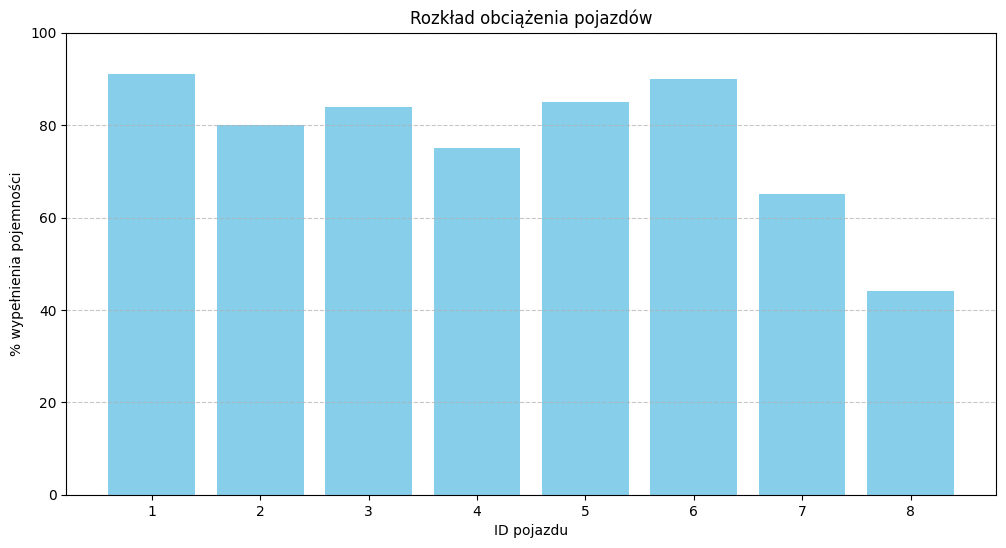

In [11]:

# Funkcja do wizualizacji wyników

def visualize_results(vehicle_routes, vehicle_loads, route_distances):
    vehicles = list(vehicle_routes.keys())

    # Oblicz sumę długości tras
    total_distance = sum(route_distances)
    print(f"Suma długości zoptymalizowanych tras pojazdów: {total_distance:.2f} jednostek")

    # Oblicz procentowe wypełnienie przestrzeni wszystkich pojazdów
    total_load = sum(vehicle_loads)
    total_capacity = len(vehicle_routes) * VEHICLE_CAPACITY
    capacity_usage_percentage = (total_load / total_capacity) * 100
    print(f"Procentowe wypełnienie przestrzeni wszystkich pojazdów: {capacity_usage_percentage:.2f}%")

    # Rozkład obciążenia pojazdów
    capacity_usage = [load / VEHICLE_CAPACITY * 100 for load in vehicle_loads]

    plt.figure(figsize=(12, 6))
    plt.bar(vehicles, capacity_usage, color="skyblue")
    plt.xlabel("ID pojazdu")
    plt.ylabel("% wypełnienia pojemności")
    plt.title("Rozkład obciążenia pojazdów")
    plt.ylim(0, 100)
    plt.xticks(vehicles)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Przykład danych wynikowych
vehicle_loads = []  # Obciążenia dla każdego pojazdu
route_distances = []  # Długości tras dla każdego pojazdu

# Oblicz obciążenia i długości tras
for vehicle, route in vehicle_routes.items():
    total_load = sum(package_sizes[client - 1] for client in route)
    vehicle_loads.append(total_load)

    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += nx.shortest_path_length(
            graph,
            source=customer_nodes[route[i] - 1],
            target=customer_nodes[route[i + 1] - 1],
            weight="length",
        )

    total_distance += nx.shortest_path_length(
        graph, source=depot_node, target=customer_nodes[route[0] - 1], weight="length"
    )
    total_distance += nx.shortest_path_length(
        graph, source=depot_node, target=customer_nodes[route[-1] - 1], weight="length"
    )

    route_distances.append(total_distance)

# Generowanie wizualizacji
visualize_results(vehicle_routes, vehicle_loads, route_distances)



### Wizualizacja tras na mapie

W tej komórce zdefiniowana została funkcja `visualize_routes`, która umożliwia wizualizację tras pojazdów na mapie przy użyciu biblioteki Folium. Funkcja generuje interaktywne mapy dla każdego pojazdu oraz mapę główną przedstawiającą wszystkie trasy. 

#### Główne kroki wizualizacji:
1. **Lokalizacja magazynu i klientów:**
   - Współrzędne magazynu (`depot_node`) i klientów (`customer_nodes`) są pobierane z grafu.
   - Klienci są oznaczani na mapie jako niebieskie markery z informacją o zapotrzebowaniu (`package_sizes`).

2. **Przygotowanie kolorów tras:**
   - Każda trasa pojazdu jest rysowana w innym kolorze, aby ułatwić rozróżnienie.

3. **Rysowanie tras dla pojazdów:**
   - Dla każdego pojazdu:
     - Trasa jest zdefiniowana jako `magazyn -> klienci -> magazyn`.
     - Każdy odcinek trasy jest rysowany jako linia na mapie, przy użyciu najkrótszej ścieżki z grafu (`nx.shortest_path`).

4. **Zapis map:**
   - Mapy dla poszczególnych pojazdów są zapisywane w plikach HTML (`vehicle_route_{vehicle_id}.html`).
   - Główna mapa z wszystkimi trasami jest zapisywana jako `problem_solution_krakow.html`.

#### Cechy mapy:
- **Marker magazynu:** Czerwony dom z ikoną.
- **Markery klientów:** Niebieskie ikony z informacją o zapotrzebowaniu.
- **Trasy:** Kolorowe linie, które łączą magazyn z klientami.

#### Wywołanie funkcji:
Na końcu komórki funkcja `visualize_routes` jest wywoływana dla danych tras pojazdów (`vehicle_routes`) oraz grafu. W wyniku powstają interaktywne mapy, które można otworzyć w przeglądarce, do celu analizy tras.




In [12]:
# Funkcja wizualizująca trasy na mapie

def visualize_routes(vehicle_routes, depot_node, customer_nodes, graph, package_sizes):
    """
    Wizualizacja tras na mapie i zapis każdej trasy do osobnego pliku.
    """
    # Lokalizacja magazynu
    depot_location = (graph.nodes[depot_node]["y"], graph.nodes[depot_node]["x"])
    
    # Lokalizacje klientów
    customer_locations = [(graph.nodes[node]["y"], graph.nodes[node]["x"]) for node in customer_nodes]
    
    # Główna mapa z wszystkimi trasami
    main_map = folium.Map(location=depot_location, zoom_start=13)
    folium.Marker(location=depot_location, icon=folium.Icon(color="red", icon="home", prefix="fa")).add_to(main_map)

    # Dodanie klientów na mapie
    for i, loc in enumerate(customer_locations):
        tooltip_text = f"Klient {i + 1}; Zapotrzebowanie = {package_sizes[i]}"
        folium.Marker(
            location=loc,
            icon=folium.Icon(color="blue", icon="user", prefix="fa"),
            tooltip=tooltip_text
        ).add_to(main_map)

    # Przygotowanie kolorów dla tras
    colors = [
        "royalblue",    
        "darkgreen",    
        "crimson",      
        "goldenrod",    
        "darkslategray",
        "sienna",       
        "darkorange",   
        "deepskyblue",  
        "mediumseagreen",
        "dodgerblue",   
        "tomato",       
        "orchid",       
        "chocolate"     
    ]

    # Rysowanie tras dla każdego pojazdu
    for vehicle_id, route in vehicle_routes.items():
        if route:
            # Pełna trasa: magazyn -> klienci -> magazyn
            full_route = [depot_node] + [customer_nodes[client - 1] for client in route] + [depot_node]
            vehicle_map = folium.Map(location=depot_location, zoom_start=13)
            folium.Marker(location=depot_location, icon=folium.Icon(color="red", icon="home", prefix="fa")).add_to(vehicle_map)

            # Dodanie klientów na mapie pojazdu
            for i, loc in enumerate(customer_locations):
                tooltip_text = f"Klient {i + 1}: Zapotrzebowanie = {package_sizes[i]}"
                folium.Marker(
                    location=loc,
                    icon=folium.Icon(color="blue", icon="user", prefix="fa"),
                    tooltip=tooltip_text
                ).add_to(vehicle_map)

            # Rysowanie trasy
            for i in range(len(full_route) - 1):
                path = nx.shortest_path(graph, full_route[i], full_route[i + 1], weight="length")
                coordinates = [(graph.nodes[node]["y"], graph.nodes[node]["x"]) for node in path]
                folium.PolyLine(
                    coordinates, color=colors[vehicle_id % len(colors)], weight=2.5, opacity=1
                ).add_to(main_map)
                folium.PolyLine(
                    coordinates, color=colors[vehicle_id % len(colors)], weight=2.5, opacity=1
                ).add_to(vehicle_map)

            # Zapis mapy pojazdu
            vehicle_map.save(f"vehicle_route_{vehicle_id}.html")
            print(f"Mapa dla pojazdu {vehicle_id} zapisana jako vehicle_route_{vehicle_id}.html")

    # Zapis głównej mapy z wszystkimi trasami
    main_map.save("problem_solution_krakow.html")
    print("Mapa główna zapisana jako problem_solution_krakow.html")

# Wywołanie funkcji wizualizacji
visualize_routes(vehicle_routes, depot_node, customer_nodes, graph, package_sizes)


Mapa dla pojazdu 1 zapisana jako vehicle_route_1.html
Mapa dla pojazdu 2 zapisana jako vehicle_route_2.html
Mapa dla pojazdu 3 zapisana jako vehicle_route_3.html
Mapa dla pojazdu 4 zapisana jako vehicle_route_4.html
Mapa dla pojazdu 5 zapisana jako vehicle_route_5.html
Mapa dla pojazdu 6 zapisana jako vehicle_route_6.html
Mapa dla pojazdu 7 zapisana jako vehicle_route_7.html
Mapa dla pojazdu 8 zapisana jako vehicle_route_8.html
Mapa główna zapisana jako problem_solution_krakow.html


### Rozwiązanie problemu CVRP za pomocą OR-Tools

W tej sekcji zaimplementowano rozwiązanie problemu Capacitated Vehicle Routing Problem (CVRP) przy użyciu biblioteki OR-Tools. Kod został opracowany z myślą o adaptacji problemu rozwiązywanego wcześniej za pomocą algorytmu genetycznego, przy jednoczesnym wykorzystaniu możliwości oferowanych przez narzędzia OR-Tools.

Ze względu na specyfikę OR-Tools, konieczne było uprzednie określenie liczby pojazdów, co różni się od podejścia algorytmu genetycznego, który mógł dynamicznie optymalizować ich liczbę. Oznacza to, że w tej implementacji pominięto pełną funkcjonalność problemu plecakowego, w którym minimalizacja liczby pojazdów jest częścią rozwiązania. Wynika to z ograniczeń narzędzia OR-Tools, które uniemożliwia jednoczesne optymalizowanie zarówno liczby pojazdów, jak i ich przypisania na podstawie wag wyznaczonych przez określoną heurystykę.

Mimo tych różnic rozwiązanie bazujące na OR-Tools pozwala na efektywne przypisanie pojazdów do zadań oraz optymalizację tras w ramach zdefiniowanej liczby pojazdów, co czyni je odpowiednim narzędziem do analizy porównawczej z algorytmem genetycznym.

#### Główne kroki działania kodu:

1. **Inicjalizacja danych wejściowych:**
   - Współrzędne magazynu (`depot_node`) i klientów (`customer_nodes`) są losowo wybierane z grafu drogowego wygenerowanego za pomocą biblioteki OSMnx.
   - Dla każdego klienta losowane jest zapotrzebowanie w zakresie od 5 do 20 jednostek.
   - Pojazdy mają zdefiniowaną maksymalną pojemność (`vehicle_capacity = 100`).

2. **Tworzenie macierzy odległości:**
   - Funkcja `create_distance_matrix` generuje macierz odległości na podstawie najkrótszych ścieżek między węzłami grafu.
   - Jeśli dwa węzły nie są połączone, odległość ustawiana jest na nieskończoność (`float('inf')`).

3. **Modelowanie problemu:**
   - **RoutingIndexManager:** Zarządza indeksami węzłów (np. mapuje rzeczywiste węzły grafu na indeksy używane przez OR-Tools).
   - **RoutingModel:** Tworzy model trasowania pojazdów z ograniczeniami pojemności.

4. **Definicja funkcji kosztu i ograniczeń:**
   - **Funkcja kosztu (`distance_callback`):** Oblicza odległość między dwoma węzłami na podstawie macierzy odległości.
   - **Ograniczenia pojemności (`demand_callback`):** Dodaje warunek, że suma zapotrzebowania klientów obsługiwanych przez jeden pojazd nie może przekroczyć jego maksymalnej pojemności.

5. **Strategia wyszukiwania:**
   - **PATH_CHEAPEST_ARC:** Algorytm zaczyna od najtańszych krawędzi w grafie.
   - Czas wyszukiwania ograniczony jest do 30 sekund, aby zapewnić szybkie uzyskanie rozwiązania.

6. **Generowanie i wyświetlanie tras:**
   - Dla każdego pojazdu odczytywana jest trasa i zapisywana w słowniku `vehicle_routes`.
   - Trasy są wyświetlane w czytelnej formie, a każda z nich jest analizowana pod kątem obciążenia pojazdu.

#### Weryfikacja pojemności pojazdów:
- Funkcja `verify_vehicle_capacity` sumuje zapotrzebowanie klientów obsługiwanych przez każdy pojazd.
- Weryfikacja informuje, czy obciążenie pojazdu nie przekracza jego maksymalnej pojemności. W przypadku przekroczenia wyświetlany jest odpowiedni komunikat.

#### Przykładowe wyniki:
- Dla każdego pojazdu wyświetlane są optymalne trasy oraz obciążenie pojazdu w stosunku do jego maksymalnej pojemności.
- Weryfikacja zapewnia zgodność wyników z ograniczeniami problemu CVRP.

#### Zastosowanie kodu:
Kod został zaprojektowany zgodnie z oficjalnym opisem problemu CVRP udostępnionym przez Google OR-Tools. Jego elastyczność pozwala na łatwe dostosowanie do innych instancji problemu, takich jak różne grafy drogowe, liczby pojazdów czy zapotrzebowanie klientów.




In [13]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np
import networkx as nx
import osmnx as ox
import random

# Ustawienie ziarna
def set_seed(seed=2025):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Ziarno ustawione na: {seed}")

set_seed()

# Tworzenie macierzy odległości z grafu NetworkX
def create_distance_matrix(graph, depot_node, customer_nodes):
    nodes = [depot_node] + customer_nodes
    size = len(nodes)
    distance_matrix = np.zeros((size, size))
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            if i != j:
                try:
                    distance = nx.shortest_path_length(graph, source=node_i, target=node_j, weight="length")
                    distance_matrix[i][j] = distance
                except nx.NetworkXNoPath:
                    distance_matrix[i][j] = float('inf')  # Brak połączenia
    return distance_matrix

# Weryfikacja pojemności pojazdów
def verify_vehicle_capacity(vehicle_routes, demands, vehicle_capacity):
    print("\nWeryfikacja pojemności pojazdów:")
    for vehicle_id, route in vehicle_routes.items():
        total_load = sum(demands[client] for client in route if client != 0)  # Pomijamy magazyn (0)
        status = "OK" if total_load <= vehicle_capacity else "PRZEKROCZENIE"
        print(f"Pojazd {vehicle_id + 1}: Obciążenie = {total_load}/{vehicle_capacity} ({status})")

# Przygotowanie danych dla grafu
CENTER_LOCATION = (50.0619474, 19.9368564)  # Kraków
RADIUS = 5000
NUM_CUSTOMERS = 50

# Generowanie grafu drogowego
graph = ox.graph_from_point(CENTER_LOCATION, dist=RADIUS, network_type="drive")
nodes = list(graph.nodes)
depot_node = random.choice(nodes)
customer_nodes = random.sample([node for node in nodes if node != depot_node], NUM_CUSTOMERS)

# Tworzenie macierzy odległości
distance_matrix = create_distance_matrix(graph, depot_node, customer_nodes)
num_customers = len(customer_nodes)
num_vehicles = 10
depot_index = 0

# Paczki i pojemność pojazdów
demands = [0] + [random.randint(5, 20) for _ in range(num_customers)]  # Paczki dla klientów
vehicle_capacity = 100

# OR-Tools CVRP Solver
def solve_cvrp(distance_matrix, num_vehicles, depot_index, demands, vehicle_capacity):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, depot_index)
    routing = pywrapcp.RoutingModel(manager)

    # Funkcja kosztu
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Ograniczenia pojemności pojazdów
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return demands[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # Brak dodatkowego ładunku
        [vehicle_capacity] * num_vehicles,  # Pojemności pojazdów
        True,  # Czy każdy pojazd zaczyna od zera
        "Capacity"
    )

    # Parametry rozwiązania
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.time_limit.seconds = 30

    # Rozwiązanie
    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print("Nie znaleziono rozwiązania!")
        return None

    # Wyświetlanie tras
    vehicle_routes = {}
    for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Dodanie punktu końcowego
        vehicle_routes[vehicle_id] = route

    return vehicle_routes

# Rozwiązanie problemu
vehicle_routes = solve_cvrp(distance_matrix, num_vehicles, depot_index, demands, vehicle_capacity)

# Wyświetlenie wyników
if vehicle_routes:
    print("\nOptymalne trasy pojazdów:")
    for vehicle_id, route in vehicle_routes.items():
        if len(route) > 2 or (len(route) == 2 and route[0] != route[1]):
            print(f"Pojazd {vehicle_id + 1}: Trasa {route}")

    # Weryfikacja pojemności pojazdów
    verify_vehicle_capacity(vehicle_routes, demands, vehicle_capacity)


Ziarno ustawione na: 2025

Optymalne trasy pojazdów:
Pojazd 4: Trasa [0, 2, 1, 0]
Pojazd 5: Trasa [0, 9, 7, 6, 5, 4, 3, 0]
Pojazd 6: Trasa [0, 16, 15, 14, 13, 12, 11, 10, 8, 0]
Pojazd 7: Trasa [0, 24, 23, 22, 21, 20, 19, 18, 17, 0]
Pojazd 8: Trasa [0, 32, 31, 30, 29, 28, 27, 26, 25, 0]
Pojazd 9: Trasa [0, 41, 40, 39, 38, 37, 36, 35, 34, 0]
Pojazd 10: Trasa [0, 50, 49, 48, 47, 46, 45, 44, 43, 42, 33, 0]

Weryfikacja pojemności pojazdów:
Pojazd 1: Obciążenie = 0/100 (OK)
Pojazd 2: Obciążenie = 0/100 (OK)
Pojazd 3: Obciążenie = 0/100 (OK)
Pojazd 4: Obciążenie = 32/100 (OK)
Pojazd 5: Obciążenie = 98/100 (OK)
Pojazd 6: Obciążenie = 91/100 (OK)
Pojazd 7: Obciążenie = 100/100 (OK)
Pojazd 8: Obciążenie = 97/100 (OK)
Pojazd 9: Obciążenie = 96/100 (OK)
Pojazd 10: Obciążenie = 100/100 (OK)


#### Funkcja długości tras

In [14]:
# Funkcja do obliczania długości trasy
def calculate_route_length(route, distance_matrix):
    total_length = 0
    for i in range(len(route) - 1):
        total_length += distance_matrix[route[i]][route[i + 1]]
    return total_length

# Obliczanie długości tras i ich łącznej długości
route_lengths = {}
total_length = 0

for vehicle_id, route in vehicle_routes.items():
    if len(route) > 2:  # Pomiń pojazdy, które odwiedzają tylko magazyn
        route_length = calculate_route_length(route, distance_matrix)
        route_lengths[vehicle_id] = route_length
        total_length += route_length

# Wyświetlenie wyników
print("\nDługości tras dla każdego pojazdu:")
for vehicle_id, length in route_lengths.items():
    print(f"Pojazd {vehicle_id + 1}: Długość trasy = {length:.2f}")

print(f"\nŁączna długość wszystkich tras: {total_length:.2f}")



Długości tras dla każdego pojazdu:
Pojazd 4: Długość trasy = 17676.54
Pojazd 5: Długość trasy = 50906.13
Pojazd 6: Długość trasy = 51730.39
Pojazd 7: Długość trasy = 74857.15
Pojazd 8: Długość trasy = 52159.16
Pojazd 9: Długość trasy = 55411.50
Pojazd 10: Długość trasy = 54082.09

Łączna długość wszystkich tras: 356822.96


#### Funkcja wizualizacji tras

In [16]:
def visualize_routes(vehicle_routes, depot_node, customer_nodes, graph, demands):
    """
    Wizualizacja tras na mapie i zapis każdej trasy do osobnego pliku HTML.
    """
    # Lokalizacja magazynu
    depot_location = (graph.nodes[depot_node]["y"], graph.nodes[depot_node]["x"])

    # Lokalizacje klientów
    customer_locations = [(graph.nodes[node]["y"], graph.nodes[node]["x"]) for node in customer_nodes]

    # Główna mapa z wszystkimi trasami
    main_map = folium.Map(location=depot_location, zoom_start=13)
    folium.Marker(location=depot_location, icon=folium.Icon(color="red", icon="home", prefix="fa"), tooltip="Magazyn").add_to(main_map)

    # Dodanie klientów na mapie
    for i, loc in enumerate(customer_locations):
        tooltip_text = f"Klient {i + 1}; Zapotrzebowanie = {demands[i + 1]}"  # demands[0] to magazyn
        folium.Marker(
            location=loc,
            icon=folium.Icon(color="blue", icon="user", prefix="fa"),
            tooltip=tooltip_text
        ).add_to(main_map)

    # Przygotowanie kolorów dla tras
    colors = [
        "royalblue", "darkgreen", "crimson", "goldenrod", "darkslategray",
        "sienna", "darkorange", "deepskyblue", "mediumseagreen", "dodgerblue",
        "tomato", "orchid", "chocolate"
    ]

    # Rysowanie tras dla każdego pojazdu
    for vehicle_id, route in vehicle_routes.items():
        if len(route) > 2:  # Pomiń pojazdy, które odwiedzają tylko magazyn
            # Pełna trasa: magazyn -> klienci -> magazyn
            full_route = [depot_node] + [customer_nodes[node - 1] for node in route[1:-1]] + [depot_node]
            vehicle_map = folium.Map(location=depot_location, zoom_start=13)
            folium.Marker(location=depot_location, icon=folium.Icon(color="red", icon="home", prefix="fa")).add_to(vehicle_map)

            # Dodanie klientów na mapie pojazdu
            for i, loc in enumerate(customer_locations):
                tooltip_text = f"Klient {i + 1}; Zapotrzebowanie = {demands[i + 1]}"
                folium.Marker(
                    location=loc,
                    icon=folium.Icon(color="blue", icon="user", prefix="fa"),
                    tooltip=tooltip_text
                ).add_to(vehicle_map)

            # Rysowanie trasy
            for i in range(len(full_route) - 1):
                path = nx.shortest_path(graph, full_route[i], full_route[i + 1], weight="length")
                coordinates = [(graph.nodes[node]["y"], graph.nodes[node]["x"]) for node in path]
                folium.PolyLine(
                    coordinates, color=colors[vehicle_id % len(colors)], weight=2.5, opacity=1
                ).add_to(main_map)
                folium.PolyLine(
                    coordinates, color=colors[vehicle_id % len(colors)], weight=2.5, opacity=1
                ).add_to(vehicle_map)

            # Zapis mapy pojazdu
            vehicle_map.save(f"cvrp_ortools_route_{vehicle_id + 1}.html")
            print(f"Mapa dla pojazdu {vehicle_id + 1} zapisana jako cvrp_ortools_route_{vehicle_id + 1}.html")

    # Zapis głównej mapy z wszystkimi trasami
    main_map.save("problem_solution_ortools.html")
    print("Mapa główna zapisana jako problem_solution_ortools.html")

# Wywołanie funkcji wizualizacji
if vehicle_routes:
    visualize_routes(vehicle_routes, depot_node, customer_nodes, graph, demands)



Mapa dla pojazdu 4 zapisana jako cvrp_ortools_route_4.html
Mapa dla pojazdu 5 zapisana jako cvrp_ortools_route_5.html
Mapa dla pojazdu 6 zapisana jako cvrp_ortools_route_6.html
Mapa dla pojazdu 7 zapisana jako cvrp_ortools_route_7.html
Mapa dla pojazdu 8 zapisana jako cvrp_ortools_route_8.html
Mapa dla pojazdu 9 zapisana jako cvrp_ortools_route_9.html
Mapa dla pojazdu 10 zapisana jako cvrp_ortools_route_10.html
Mapa główna zapisana jako problem_solution_ortools.html
